# Playing with wawy things

In [120]:
import numpy as np
from scipy.interpolate import griddata

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [223]:
D = (6, 6)

## Geneating grid for the simulation

In [328]:
res = 80
xi = np.linspace(0, D[0], D[0]*res)
yi = np.linspace(0, D[1], D[1]*res)
X, Y = np.meshgrid(xi, yi)
coords = np.vstack((X.flatten(), Y.flatten())).T

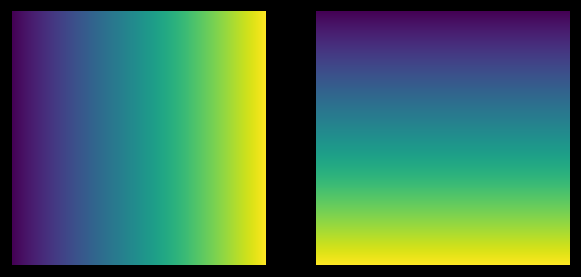

In [329]:
nr, nc = 1, 2
fig, axes = plt.subplots(nr, nc, figsize=(nr*D[0], nc*D[1]), dpi=120,
                         facecolor='black')
axes = axes.flatten()

for ax, C in zip(axes, [X, Y]):
    ax.axis('off')
    ax.imshow(C)

plt.show()

## Field of random particles

In [403]:
N = 2000
x = np.random.uniform(X.min(), X.max(), size=N)
y = np.random.uniform(Y.min(), Y.max(), size=N)
points = np.vstack((x.flatten(), y.flatten())).T

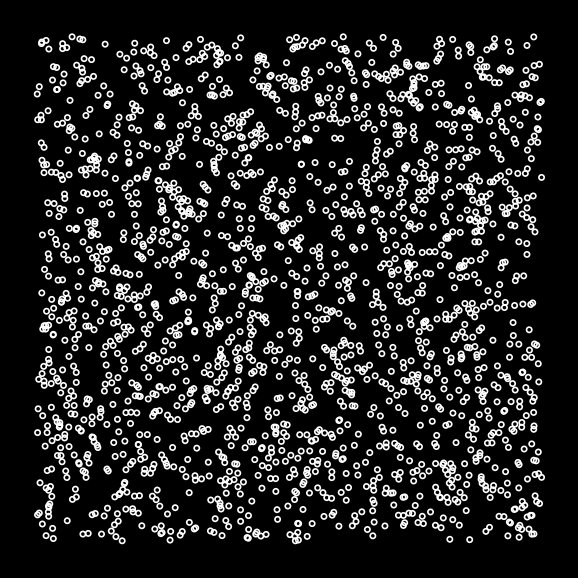

In [404]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='black')
ax.set_aspect('equal')
ax.axis('off')

ax.scatter(*points.T, color='white', marker='o', fc='none', s=10)

plt.show()

## Generating 2D waves

### Basic generation

In [332]:
A = 1.0
c = 1.0

In [333]:
def wave(t, X, Y, x0, y0, A, c, noise=True):
    r = np.sqrt((X-x0)**2 + (Y-y0)**2)
    wave = A * np.heaviside(t - r/c, 1) * np.cos(2*np.pi*(t - r/c))
    if noise:
        wave += np.random.normal(0, A/8, X.shape)
    return wave

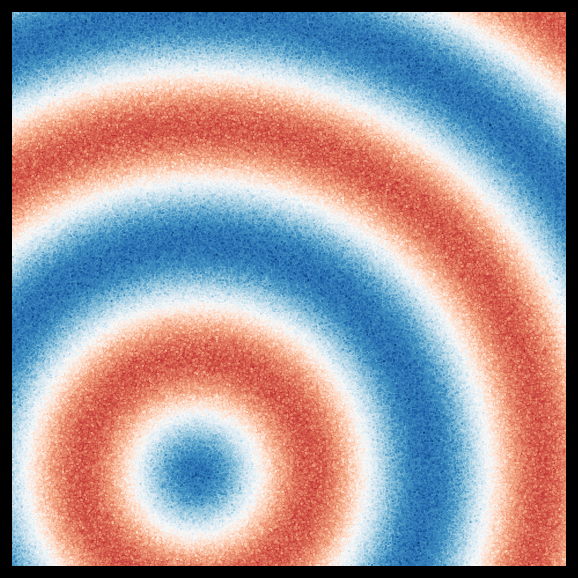

In [334]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='black')
ax.set_aspect('equal')
ax.axis('off')

Z = wave(t=10, X=X, Y=Y, x0=2, y0=1, A=1.0, c=2.5)
ax.contourf(X, Y, Z, levels=np.linspace(np.min(Z), np.max(Z), 50), cmap='RdBu')

plt.show()

### Interference of waves from symmetrically placed point sources

In [141]:
a = 6
l = 3
xy1 = (a/2, a/2 + l)
xy2 = (a/2 - l*np.sqrt(3)/2, a/2 - l/2)
xy3 = (a/2 + l*np.sqrt(3)/2, a/2 - l/2)

In [235]:
def polygon_vertices(a: float, l: float, n: int):
    '''
    Calculate the vertices of a regular polygon inscribed in a square.

    Parameters:
    a : float
        The side length of the square.
    l : float
        The distance from the center of the square to the top vertex of the polygon.
    n : int
        The number of sides of the polygon.

    Returns:
    vertices : list
        The coordinates of the vertices.
    '''
    if n < 2:
        raise ValueError("The number of sides `n` must be at least 2.")
    center_x, center_y = a/2, a/2
    vertices = []
    for i in range(n):
        angle = 2 * np.pi * i / n
        x = center_x + l * np.cos(angle)
        y = center_y + l * np.sin(angle)
        vertices.append((x, y))
    return vertices

In [243]:
a, l, n = 6, 3, 7
vertices = polygon_vertices(a=a, l=l, n=n)

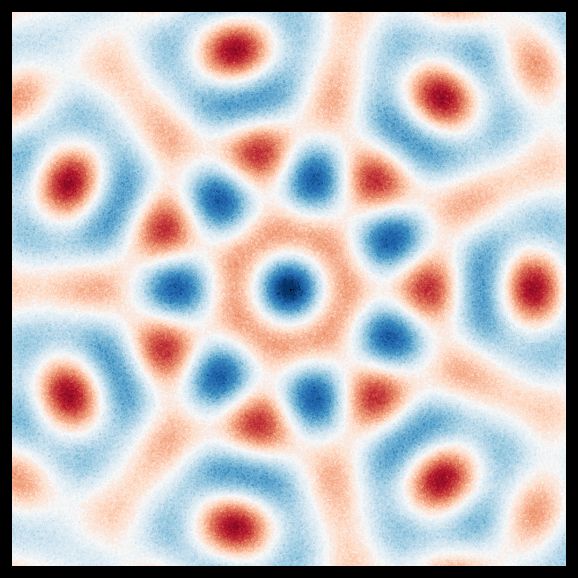

In [244]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='black')
ax.set_aspect('equal')
ax.axis('off')

t = 10
Z = np.zeros_like(X)
for x0, y0 in vertices:
    Z += wave(t=t, X=X, Y=Y, x0=x0, y0=y0, A=1.0, c=1.0)
ax.contourf(X, Y, Z, levels=np.linspace(-n, n, 50), cmap='RdBu')

plt.show()

## Visualize waves with particles

In [245]:
from scipy.interpolate import griddata

In [406]:
t = 10
x0, y0 = 2, 1

In [407]:
Z = wave(t=t, X=X, Y=Y, x0=x0, y0=y0, A=1.0, c=2.0)
Z_interp = griddata(coords, Z.flatten(), points, method='cubic')
Z_shift  = Z_interp - np.min(Z_interp)
Z_normed = Z_shift / np.max(Z_shift)

In [408]:
def color_waves(Z_normed, cmap=None):
    '''
    Generate colormaps
    '''
    if cmap is None:
        cmap = cm.Blues_r
    colors = cmap(Z_normed)
    colors_a = colors.copy()
    colors_a[:, -1] = 0.3

    return colors, colors_a

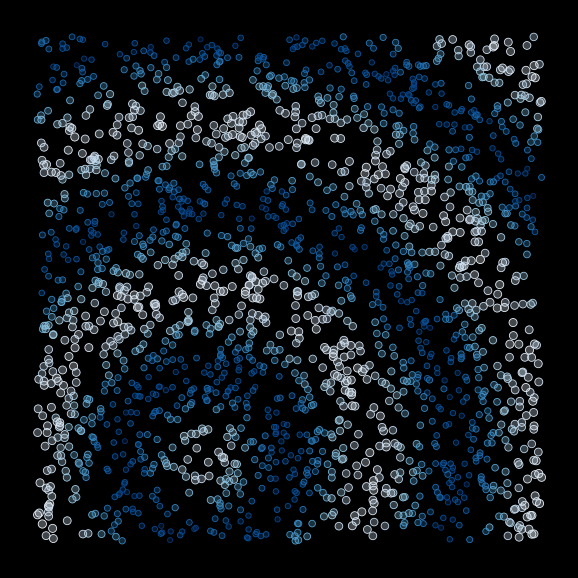

In [410]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='black')
ax.set_aspect('equal')
ax.axis('off')

sizes = Z_normed * 16 + 9
ec, fc = color_waves(Z_normed)
ax.scatter(*points.T, fc=fc, ec=ec, lw=0.5, marker='o', s=sizes)

plt.show()

### Rocking particles dues to waves

In [413]:
def rocking(Z, x, y, x0, y0):

    # Outward normed directions from the source
    directions = np.vstack((x - x0, y - y0)).T
    norms = np.sqrt((directions ** 2).sum(axis=-1))
    directions /= norms[:, np.newaxis]

     # Calculate radial distance from source
    r = np.sqrt((x - x0) ** 2 + (y - y0) ** 2)
    # Calculate phase velocity
    phase_velocity = -np.sin(2*np.pi*(t - r/c))

    # Compute the movements of the particles based on the wave amplitude
    disp = Z[:, np.newaxis] * directions * 0.15

    return x+disp[:, 0], y+disp[:, 1]

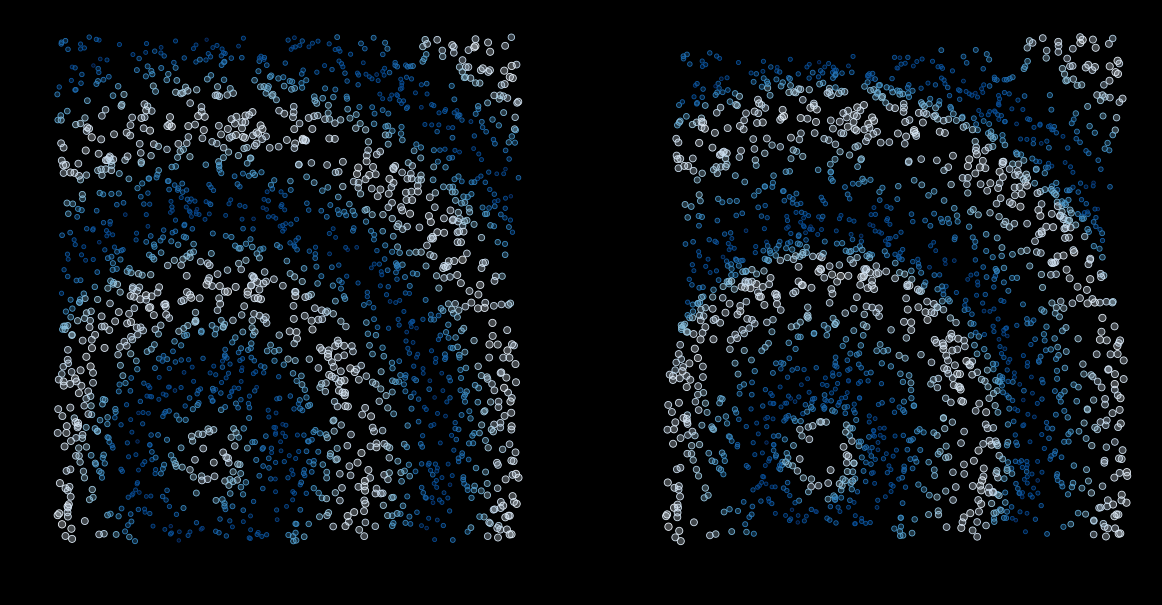

In [420]:
nr, nc = 1, 2
fig, axes = plt.subplots(nr, nc, figsize=(nc*D[0], nr*D[1]), dpi=120,
                         facecolor='black', subplot_kw={'facecolor' : 'black'})
axes = axes.flatten()

sizes = Z_normed * 16 + 4
ec, fc = color_waves(Z_normed)
axes[0].scatter(x, y, fc=fc, ec=ec, lw=0.5, marker='o', s=sizes)

xnew, ynew = rocking(Z_interp, x, y, x0, y0)
axes[1].scatter(xnew, ynew, fc=fc, ec=ec, lw=0.5, marker='o', s=sizes)

plt.show()

## Animate surface waves

In [417]:
def animate(i):
    t = i/10
    x0, y0 = 2, 1
    Z = wave(t=t, X=X, Y=Y, x0=x0, y0=y0, A=1.0, c=2.0)
    Z_interp = griddata(coords, Z.flatten(), points, method='cubic')
    Z_shift  = Z_interp - np.min(Z_interp)
    Z_normed = Z_shift / np.max(Z_shift)

    sizes = Z_normed * 16 + 9
    ec, fc = color_waves(Z_normed)
    #x, y = rocking(Z_interp, *points_new.T, x0, y0)
    #points_new = np.vstack((x.flatten(), y.flatten())).T
    
    ax.clear()
    ax.scatter(*points.T, fc=fc, ec=ec, lw=0.5, marker='o', s=sizes)

In [418]:
%%time
animate(i=200)

CPU times: user 5.01 s, sys: 1.11 s, total: 6.12 s
Wall time: 4.5 s


CPU times: user 2min 32s, sys: 34.1 s, total: 3min 7s
Wall time: 2min 17s


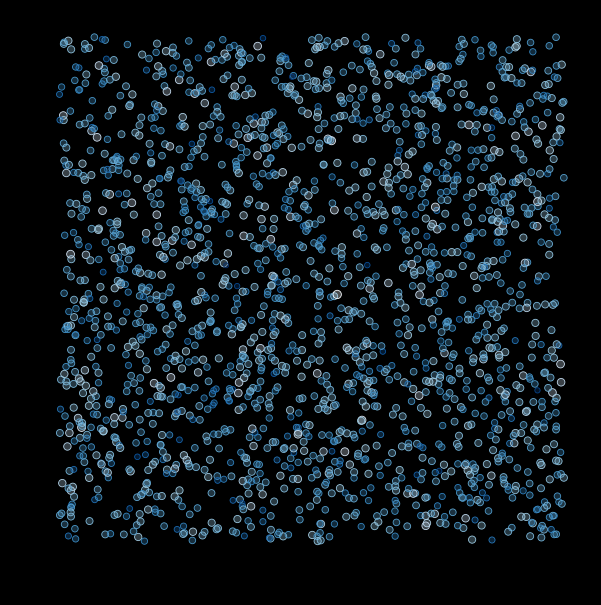

In [419]:
%%time
fig, ax = plt.subplots(figsize=D, dpi=120,
                       facecolor='black', subplot_kw={'facecolor': 'black'})
ax.set_aspect('equal')
ax.axis('off')
ani = animation.FuncAnimation(fig, animate, frames=30)

# Save animation
ani.save('wave_animation.mp4', fps=15, writer='ffmpeg')
# or save as gif
# ani.save('wave_animation.gif', writer='imagemagick')

In [445]:
class Wave:
    def __init__(self, amplitude, velocity, x0, y0):
        self.A = amplitude
        self.c = velocity
        self.x0 = x0
        self.y0 = y0

        self.wave = None

    def calc(self, t, X, Y, noise=True):
        r = np.sqrt((X-self.x0)**2 + (Y-self.y0)**2)
        wave  = self.A * np.cos(2*np.pi*(t - r/self.c))
        wave *= np.heaviside(t - r/self.c, 1)
        if noise:
            wave += np.random.normal(0, self.A/8, X.shape)
        self.wave = wave

In [446]:
test_wave = Wave(amplitude=1.0, velocity=2.0, x0=1, y0=5)

In [470]:
class WaveSimulation:
    def __init__(self,
                 domain_size, resolution, num_particles):
        self.D = domain_size
        self.res = resolution
        self.N = num_particles

        self.X, self.Y = self.__setup_space()
        self.particles = self.__initialize_particles()
        self.wave = np.zeros(self.X.shape)

    def __setup_space(self):
        xi = np.linspace(0, self.D[0], self.D[0]*self.res)
        yi = np.linspace(0, self.D[1], self.D[1]*self.res)
        return np.meshgrid(xi, yi)

    def __initialize_particles(self):
        return np.random.uniform([self.X.min(), self.Y.min()],
                                 [self.X.max(), self.Y.max()],
                                 size=(self.N, 2))

    def add_wave(self, t, amplitude, velocity, x0, y0, noise=True):
        new_wave = Wave(amplitude, velocity, x0, y0)
        new_wave.calc(t, self.X, self.Y, noise)
        self.wave += new_wave.wave
    
    def interpolate(self):
        points = np.vstack((self.X.flatten(), self.Y.flatten())).T
        values = self.wave.flatten()
        return griddata(points, values, self.particles, method='cubic')

In [477]:
sim = WaveSimulation(domain_size=(6, 6), resolution=80, num_particles=1000)
sim.add_wave(t=10, amplitude=1.0, velocity=2.0, x0=1, y0=4.0, noise=True)
sim.add_wave(t=10, amplitude=1.0, velocity=2.0, x0=5, y0=2.0, noise=True)
sim.add_wave(t=2, amplitude=1.0, velocity=2.0, x0=0, y0=2.0, noise=True)

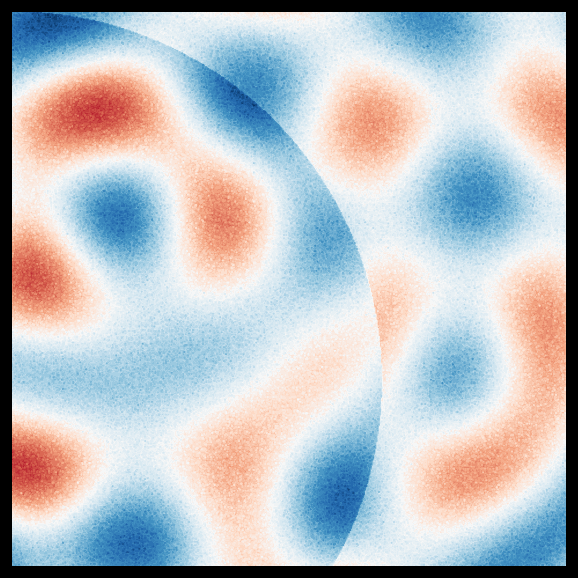

In [478]:
fig, ax = plt.subplots(figsize=D, dpi=120, facecolor='black')
ax.set_aspect('equal')
ax.axis('off')

ax.contourf(sim.X, sim.Y, sim.wave,
            levels=np.linspace(np.min(sim.wave), np.max(sim.wave), 50),
            cmap='RdBu')

plt.show()

In [472]:
Z_interp = sim.interpolate()

In [423]:

    def displacement(self, wave, x0, y0):
        x0, y0, c = wave.x0, wave.y0, wave.c
        directions = self.particles - np.array([x0, y0])
        norms = np.sqrt((directions ** 2).sum(axis=-1))
        directions /= norms[:, np.newaxis]
        r = np.sqrt(((self.particles - np.array([x0, y0])) ** 2).sum(axis=-1))
        phase_velocity = -np.sin(2*np.pi*(t - r/c))

        return wave.wave[:, np.newaxis] * directions * phase_velocity[:, np.newaxis] * 0.15

    def calculate_displacement(self, wave_amplitude, t, x0, y0, A, c):
        directions = self.particles - np.array([x0, y0])
        norms = np.sqrt((directions ** 2).sum(axis=-1))
        directions /= norms[:, np.newaxis]

        r = np.sqrt(((self.particles - np.array([x0, y0])) ** 2).sum(axis=-1))
        phase_velocity = -np.sin(2*np.pi*(t - r/c))

        return wave_amplitude[:, np.newaxis] * directions * phase_velocity[:, np.newaxis] * 0.15

    def update_particles(self, displacement):
        self.particles += displacement
        self.particles = np.mod(self.particles, [self.D[0], self.D[1]])  # Wrap particles around to the other side of the domain

    def step(self, x0, y0, dt):
        wave = self.calculate_wave(t, x0, y0)
        wave_amplitude = self.interpolate_wave(wave)
        displacement = self.calculate_displacement(wave_amplitude, t, x0, y0)
        self.update_particles(displacement)
        yield self.particles

In [424]:
def visualize(simulation, total_frames, fps):
    fig, ax = plt.subplots(figsize=simulation.D, dpi=120, facecolor='black')
    ax.set_aspect('equal')
    ax.axis('off')

    particles = simulation.particles
    scatter = ax.scatter(particles[:, 0], particles[:, 1], s=1, alpha=0.6, color='white')
    ax.set_xlim(0, simulation.D[0])
    ax.set_ylim(0, simulation.D[1])

    def update(frame):
        nonlocal particles
        particles = next(simulation.run(x0=3, y0=3, A=1, c=2.0, T=10, dt=0.1))
        scatter.set_offsets(particles)

    ani = animation.FuncAnimation(fig, update, frames=total_frames)
    plt.show()

    # Save animation
    ani.save('wave_animation.mp4', fps=fps, writer='ffmpeg')
    # or save as gif
    # ani.save('wave_animation.gif', writer='imagemagick')

In [425]:
sim = WaveSimulation(domain_size=(6, 6), resolution=80, num_particles=2000)